In [ ]:
!pip install transformers datasets


In [2]:
import torch, os
import pandas as pd
from transformers import pipeline, BertForSequenceClassification, BertTokenizerFast
from torch.utils.data import Dataset

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cpu'

In [4]:

df_org= pd.read_csv("/Users/innovapathinc/Desktop/new_agentic/email_classification_agents/job_classification_project/data/synthetic_email_data.csv")

df_org = df_org.sample(frac=1.0, random_state=42)

df_org.head()

,email_text,category
361,Hiring UI/UX designers to create stunning web ...,UI
73,Seeking ML experts with experience in LLM fine...,ML
374,Hiring UI/UX designers to create stunning web ...,UI
155,Hiring a UI/UX developer to create intuitive i...,UI
104,Join our QA team to ensure high-quality softwa...,QA


In [5]:
labels= df_org['category'].unique().tolist()
labels=[s.strip() for s in labels ]
labels

['UI', 'ML', 'QA']

# Why we need id2label and labe2ids in NLP Projects
In NLP tasks, especially those involving classification problems, id2label and label2id dictionaries are used to map class labels (categories) to integer IDs and vice versa. These mappings are essential for various stages of the NLP pipeline, such as data preprocessing, model training, and evaluation.

Data preprocessing: In order to feed text data into an NLP model, the text must first be tokenized and then converted into numerical values. Similarly, class labels must also be transformed into numerical representations. The label2id dictionary helps in converting the original class labels into integer IDs.

Model training: NLP models usually output probability distributions over classes as their predictions. During training, the model's predictions are compared against the ground truth labels (which have been converted to integer IDs) to compute the loss and optimize the model parameters.

Model evaluation and interpretation: Once the model has been trained, its predictions (in the form of integer IDs) need to be mapped back to their original class labels to make the results interpretable. The id2label dictionary is used to perform this conversion.

For BertForSequenceClassification model as well I need these exact mapping of id2labels and labels2id in dictionary form.

In [6]:
for key, value in enumerate(labels):
    print(value)

UI
ML
QA


In [7]:
NUM_LABELS=len(labels)

id2label={id : label for id,label in enumerate(labels)}
label2id={label: id for id ,label in enumerate(labels)}

In [8]:
id2label

{0: 'UI', 1: 'ML', 2: 'QA'}

In [9]:
label2id

{'UI': 0, 'ML': 1, 'QA': 2}

In [10]:
df_org["labels"]=df_org.category.map(lambda x: label2id[x.strip()])

In [11]:
df_org.head()

,email_text,category,labels
361,Hiring UI/UX designers to create stunning web ...,UI,0
73,Seeking ML experts with experience in LLM fine...,ML,1
374,Hiring UI/UX designers to create stunning web ...,UI,0
155,Hiring a UI/UX developer to create intuitive i...,UI,0
104,Join our QA team to ensure high-quality softwa...,QA,2


<Axes: ylabel='count'>

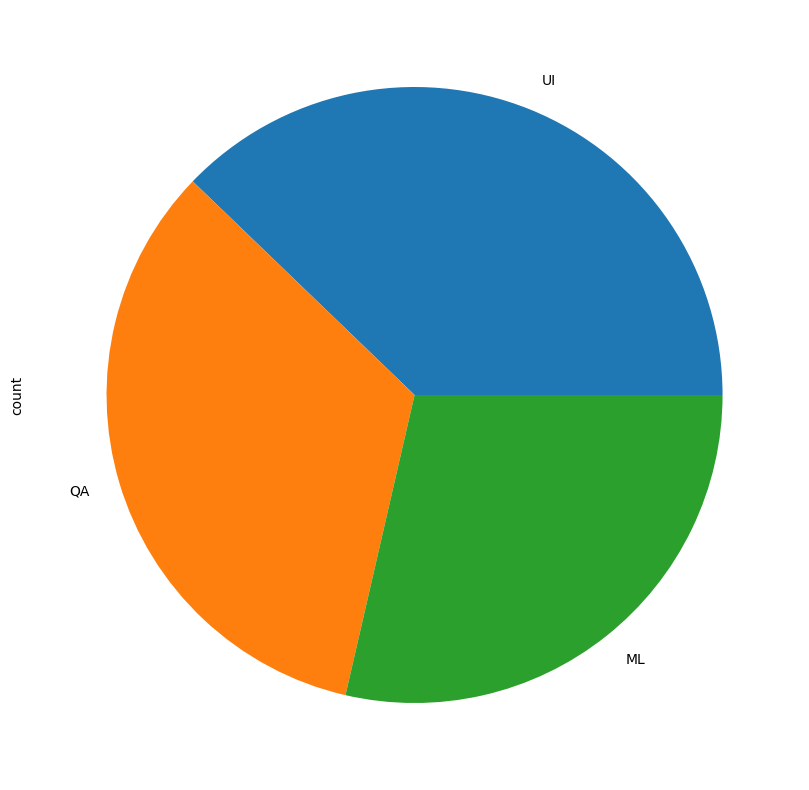

In [12]:
df_org.category.value_counts().plot(kind="pie",figsize=(10,10))

In [13]:
tokenizer=BertTokenizerFast.from_pretrained("bert-base-uncased", max_length=512)

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS, id2label=id2label, label2id=label2id)
model.to(device)

Useful information and understanding you know about the model from the above output
Model components: The model consists of several key components, such as:

Embeddings (word, position, and token type embeddings)

Encoder layers (12 layers in this case, each with self-attention, intermediate, and output components)

Layer normalization and dropout layers for regularization

GELU activation functions used in the intermediate layers

Model dimensions:

Word embeddings: The model has an embedding size of 768 dimensions and a vocabulary size of 32,000 tokens.

Position embeddings: The model can handle input sequences of up to 512 tokens in length.

Encoder layers: The model has 12 encoder layers, each with a hidden size of 768 and an intermediate layer size of 3072.

Task-specific classification layer: The BertForSequenceClassification model is designed for sequence classification tasks. It takes the final hidden state of the [CLS] token and passes it through a linear layer and a softmax function to produce class probabilities. In this case, the model is configured with a custom number of labels (NUM_LABELS) and label mappings (id2label, label2id).

## Lets understand the flow of a raw input-text > through the pretrained BERT Model > and finally coming out on the other side of the model as a class prediction in the context of this task-specific fine-tuning.

In BERT-based models like BertForSequenceClassification, the [CLS] token (short for "classification") serves as a special token that is prepended to the input sequence. It is designed to be used as an aggregate representation of the entire input sequence for classification tasks.

Here's a step-by-step breakdown of how the [CLS] token is handled during fine-tuning for a specific classification task:

Tokenization: During the pre-processing of the input text, the tokenizer inserts the [CLS] token at the beginning of the input sequence. For example, if the input text is "This is a sample sentence.", the tokenized input would look like: "[CLS] This is a sample sentence."

Embeddings: The tokenized input sequence, including the [CLS] token, is passed through the BERT model's embedding layers, which convert the tokens into continuous-valued word vectors.

Encoder layers: The embedded input sequence is then processed through the BERT model's encoder layers, which consist of self-attention mechanisms and feed-forward neural networks. During this process, the model learns to capture the semantic and syntactic information present in the input sequence, as well as any relationships between the tokens.

Final hidden state of [CLS]: At the end of the BERT model's encoder layers, each token has a corresponding hidden state vector. For the [CLS] token, its final hidden state is used as an aggregated representation of the entire input sequence. This vector is then passed to the task-specific classification layer.

Linear layer: The final hidden state of the [CLS] token is fed into a linear layer, which maps the 768-dimensional vector (assuming the base BERT model) to a vector of size equal to the number of target classes. This is essentially a weight matrix multiplication followed by a bias term addition.

Softmax function: The output of the linear layer is then passed through a softmax function, which converts the raw output values into class probabilities. The softmax function ensures that the sum of probabilities across all classes equals 1.

Prediction: The class with the highest probability is chosen as the final prediction for the given input sequence.

During task-specific fine-tuning, the model learns to adjust its weights and biases based on the training data and the target labels. This involves updating both the BERT model's pre-trained parameters and the task-specific classification layer's parameters through backpropagation and optimization techniques like gradient descent. This fine-tuning process allows the model to adapt to the specific classification task and improve its performance on the given dataset.


In [15]:

SIZE= df_org.shape[0]

train_texts= list(df_org.email_text[:SIZE//2])

val_texts=   list(df_org.email_text[SIZE//2:(3*SIZE)//4 ])

test_texts=  list(df_org.email_text[(3*SIZE)//4:])

train_labels= list(df_org.labels[:SIZE//2])

val_labels=   list(df_org.labels[SIZE//2:(3*SIZE)//4])

test_labels=  list(df_org.labels[(3*SIZE)//4:])

In [16]:
len(train_texts)


250

In [17]:
len(train_texts), len(val_texts), len(test_texts)


(250, 125, 125)

In [18]:

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings  = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

In [19]:
class DataLoader(Dataset):
    """
    Custom Dataset class for handling tokenized text data and corresponding labels.
    Inherits from torch.utils.data.Dataset.
    """
    def __init__(self, encodings, labels):
        """
        Initializes the DataLoader class with encodings and labels.

        Args:
            encodings (dict): A dictionary containing tokenized input text data
                              (e.g., 'input_ids', 'token_type_ids', 'attention_mask').
            labels (list): A list of integer labels for the input text data.
        """
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        """
        Returns a dictionary containing tokenized data and the corresponding label for a given index.

        Args:
            idx (int): The index of the data item to retrieve.

        Returns:
            item (dict): A dictionary containing the tokenized data and the corresponding label.
        """
        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        """
        Returns the number of data items in the dataset.

        Returns:
            (int): The number of data items in the dataset.
        """
        return len(self.labels)

In [20]:
train_dataloader = DataLoader(train_encodings, train_labels)

val_dataloader = DataLoader(val_encodings, val_labels)

test_dataset = DataLoader(test_encodings, test_labels)

In [21]:

from transformers import TrainingArguments, Trainer

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    """
    Computes accuracy, F1, precision, and recall for a given set of predictions.
    
    Args:
        pred (obj): An object containing label_ids and predictions attributes.
            - label_ids (array-like): A 1D array of true class labels.
            - predictions (array-like): A 2D array where each row represents
              an observation, and each column represents the probability of 
              that observation belonging to a certain class.
              
    Returns:
        dict: A dictionary containing the following metrics:
            - Accuracy (float): The proportion of correctly classified instances.
            - F1 (float): The macro F1 score, which is the harmonic mean of precision
              and recall. Macro averaging calculates the metric independently for
              each class and then takes the average.
            - Precision (float): The macro precision, which is the number of true
              positives divided by the sum of true positives and false positives.
            - Recall (float): The macro recall, which is the number of true positives
              divided by the sum of true positives and false negatives.
    """
    # Extract true labels from the input object
    labels = pred.label_ids
    
    # Obtain predicted class labels by finding the column index with the maximum probability
    preds = pred.predictions.argmax(-1)
    
    # Compute macro precision, recall, and F1 score using sklearn's precision_recall_fscore_support function
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    
    # Calculate the accuracy score using sklearn's accuracy_score function
    acc = accuracy_score(labels, preds)
    
    # Return the computed metrics as a dictionary
    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [23]:
training_args = TrainingArguments(
    # The output directory where the model predictions and checkpoints will be written
    output_dir='./TTC4900Model', 
    do_train=True,
    do_eval=True,
    #  The number of epochs, defaults to 3.0 
    num_train_epochs=3,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=32,
    # Number of steps used for a linear warmup
    warmup_steps=100,                
    weight_decay=0.01,
    logging_strategy='steps',
   # TensorBoard log directory                 
    logging_dir='./multi-class-logs',            
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps", 
    bf16=True,
    load_best_model_at_end=True
)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    # the pre-trained model that will be fine-tuned 
    model=model,
     # training arguments that we defined above                        
    args=training_args,                 
    train_dataset=train_dataloader,         
    eval_dataset=val_dataloader,            
    compute_metrics= compute_metrics
)

In [ ]:
trainer.train()

In [ ]:
q=[trainer.evaluate(eval_dataset=df_org) for df_org in [train_dataloader, val_dataloader, test_dataset]]

pd.DataFrame(q, index=["train","val","test"]).iloc[:,:5]

In [ ]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizerFast

In [ ]:
def predict(text):

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Ensure MPS or fallback to CPU
    model.to(device)  # Move model to device

    """
    Predicts the class label for a given input text

    Args:
        text (str): The input text for which the class label needs to be predicted.

    Returns:
        probs (torch.Tensor): Class probabilities for the input text.
        pred_label_idx (torch.Tensor): The index of the predicted class label.
        pred_label (str): The predicted class label.
    """
    # Tokenize the input text and move tensors to the GPU if available
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to(device)

    # Get model output (logits)
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    """ Explanation outputs: The BERT model returns a tuple containing the output logits (and possibly other elements depending on the model configuration). In this case, the output logits are the first element in the tuple, which is why we access it using outputs[0].

    outputs[0]: This is a tensor containing the raw output logits for each class. The shape of the tensor is (batch_size, num_classes) where batch_size is the number of input samples (in this case, 1, as we are predicting for a single input text) and num_classes is the number of target classes.

    softmax(1): The softmax function is applied along dimension 1 (the class dimension) to convert the raw logits into class probabilities. Softmax normalizes the logits so that they sum to 1, making them interpretable as probabilities. """


    pred_label_idx = probs.argmax()

    # Now map the predicted class index to the actual class label 
    # Since pred_label_idx is a tensor containing a single value (the predicted class index), 
    # the .item() method is used to extract the value as a scalar
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [ ]:
# Test with a an example text in Turkish
text = "Seeking ML experts with experience in LLM fine-tuning and embeddings"
# "Machine Learning itself is moving towards more and more automated"
predict(text)

(tensor([[0.1071, 0.6123, 0.2807]], device='mps:0', grad_fn=<SoftmaxBackward0>),
 tensor(1, device='mps:0'),
 'ML')

In [ ]:
model_path = "email-classification-model"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

In [ ]:
model_path = "email-classification-model"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
nlp= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

In [ ]:
nlp("")


[{'label': 'QA', 'score': 0.7626891732215881}]